2026-01-09 11:46:41,138 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-09 11:46:41,144 INFO: Initializing external client
2026-01-09 11:46:41,145 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-09 11:46:42,546 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1326229
2026-01-09 11:46:48,308 INFO: Initializing for batch retrieval of feature vectors


Downloading: 100.000%|██████████| 635265/635265 elapsed<00:00 remaining<00:00


Downloading: 100.000%|██████████| 310818/310818 elapsed<00:00 remaining<00:00


Downloading: 100.000%|██████████| 249627/249627 elapsed<00:00 remaining<00:00


Downloading: 100.000%|██████████| 225739/225739 elapsed<00:00 remaining<00:00


Downloading: 100.000%|██████████| 38576/38576 elapsed<00:00 remaining<00:00


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.71s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.75s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 


KeyError: 'pred_price'

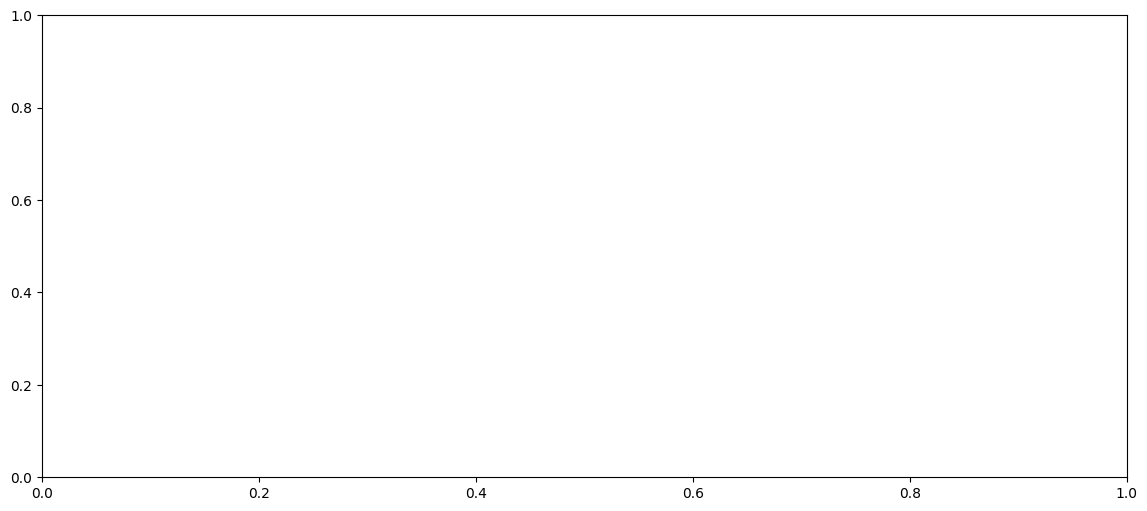

In [ ]:
import util
import datetime

import pytz

cities = {"stockholm":[59.3294,18.0687], "goteborg":[57.7072,11.9668]}
keys = list(cities.keys())
    
project = util.connect_to_hopsworks_project()

fs = util.create_fs(project)

model, fv = util.get_model(project)
starttime=first_hour = (
    datetime.now(pytz.timezone("Europe/Stockholm"))
    .replace(hour=0, minute=0, second=0, microsecond=0)
    - datetime.timedelta(days=0) 
).astimezone(pytz.UTC)
combined_data = util.get_forecast_weather(fs, starttime, keys[0], keys[1])

batch_data, first_hour, first_roll = util.add_first_price_features(fs, combined_data)
first_roll = first_roll.sort_values("date").reset_index(drop=True)
pred_data = util.predictions(first_hour, batch_data, model, first_roll)

    
model_dir,images_dir = util.create_dirs()
forecast_path = util.plot_price_forecast("SE3",batch_data, images_dir + "/forecast.png", False)

monitor_fg = util.monitoring_fg(batch_data,fs)

monitoring_df = util.monitor_df(monitor_fg)

elec_fg, elec_df = util.elprice_pred_df(fs)

hindcast_df = util.hindcast(elec_df,monitoring_df)

hindcast_path = util.plot_price_forecast("SE3",hindcast_df, images_dir + "/hindcast.png", True)
today = datetime.now()
util.upload_to_hops(project,today, forecast_path,hindcast_path)